# Accelerate SetFit Models with 🤗 Optimum Intel

In this notebook, we'll show how you can use 🤗 [Optimum Intel](https://github.com/huggingface/optimum-intel) to speed up your SetFit models on Intel CPUs.\
Optimum Intel is the interface between the 🤗 Transformers and Diffusers libraries and the different tools and libraries provided by Intel to accelerate end-to-end pipelines on Intel architectures.

In our experiments, we will be using a fine-tuned SetFit model based on `bge-small-en-v1.5` sentence transformer model and observe our performance increase.

### Prerequisites

* Linux OS
* Python 3.9+
* An Intel Xeon Processor which supports [bfloat16](https://www.intel.com/content/www/us/en/developer/articles/technical/pytorch-on-xeon-processors-with-bfloat16.html)

Since Google Colab doesn't meet the hardware requirement, it's incompatible with this notebook and will not see speedups from our optimizations.

Please run the following to ensure you meet the requirements.

In [1]:
import sys
import os
from time import sleep

os_info = !uname -o
os_type = os_info[0]
is_os_ok = "linux" in os_type.lower()
is_python_ver_ok = sys.version_info.major == 3 and sys.version_info.minor >=9
cpu_info = !lscpu
is_cpu_ok = "intel" in cpu_info.grep("vendor")[0].lower() and "bf16" in cpu_info.grep("flags")[0]
if not is_os_ok:
    print(f"This notebook requires a Linux type operating system, but you have {os_type}")
if not is_python_ver_ok:
    print(f"This notebook requires Python 3.9+ but your version is {sys.version.split()[0]}.")
if not is_cpu_ok:
    print(f"Your CPU does not support bfloat16.")
print(f"Notebook requirements {'' if is_os_ok and is_python_ver_ok and is_cpu_ok else 'not'} met.")

Notebook requirements  met.


### Reproducibility Note
This notebook was tested on `Ubuntu 22.04.3 LTS` and `Python 3.9.18`.

To reproduce the maximum speeds reported in this notebook, please launch it locally, using `numactl`.\
`numactl` enables gaining better control on which resources you're running. It's best to run on a single socket (`-m 0`):\
`OMP_NUM_THREADS=<NUM_THREADS> numactl -C <CORES_RANGE> -m 0 jupyter notebook`

For example, if cores 0-59 are available, you can run with one thread per core like so:\
`OMP_NUM_THREADS=60 numactl -C 0-59 -m 0 jupyter notebook`

### Setup
Install the required packages to evaluate and visualize results for SetFit models:

In [2]:
!python -m pip install -U setfit evaluate matplotlib -qqq

### Set Up Benchmark

First, define the infrastructure for conducting latency, throughput and accuracy benchmarks.

In [3]:
from pathlib import Path
from time import perf_counter
import os
import warnings
import subprocess
import sys
from collections import defaultdict

import evaluate
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import trange
from sentence_transformers import SentenceTransformer

warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def get_dir_size(path):
    ps = subprocess.Popen(('du','-hk', path), stdout=subprocess.PIPE)
    output = subprocess.check_output(("awk", "{print $1/1024,$2}"), stdin=ps.stdout)
    ps.wait()
    return float(output.split()[0].decode('utf-8'))

class PerformanceBenchmark:
    def __init__(self, model, dataset, optim_type, metric="accuracy",
                 model_path=None, enable_autocast=False, batch_sizes=np.exp2(range(2, 9))):
        self.model = model
        self.dataset = dataset
        self.optim_type = optim_type
        self.metric = evaluate.load(metric)
        self.model_path = model_path
        self.batch_sizes = batch_sizes
        self.enable_autocast = enable_autocast
        self.batch_sizes = [1] + list(map(int, batch_sizes))
        if hasattr(self.model, "model_body"):
            self.tokenizer = self.model.model_body.tokenizer
            self.has_sentence_transformer_body = isinstance(self.model.model_body, SentenceTransformer)
        else:
            self.tokenizer = self.model.tokenizer
            self.has_sentence_transformer_body = False
        self.vocab_size = self.tokenizer.vocab_size

    def generate_random_sequences(self, batch_size, sequence_length):
        input_ids = torch.randint(0, self.vocab_size - 1, (batch_size, sequence_length))
        return self.tokenizer.batch_decode(input_ids)

    def timed_predict(self, inputs, **kwargs):
        if not self.has_sentence_transformer_body:
            kwargs.pop("batch_size", None)
        with torch.no_grad(), torch.cpu.amp.autocast(enabled=self.enable_autocast):
            start = perf_counter()
            return self.model(inputs, **kwargs), perf_counter() - start

    def compute_accuracy(self):
        preds, time = self.timed_predict(self.dataset["text"], batch_size=128)
        labels = self.dataset["label"]
        accuracy = self.metric.compute(predictions=preds, references=labels)
        print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
        return accuracy

    def compute_size(self):
        if self.model_path is None:
            state_dict = self.model.model_body.state_dict()
            tmp_path = Path("model.pt")
            torch.save(state_dict, tmp_path)
            size_mb = get_dir_size(tmp_path)
            # Delete temporary file
            tmp_path.unlink()
        else:
            size_mb = get_dir_size(self.model_path)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

    def compute_latency_and_throughput(self, num_samples=1000, warmup=200, sequence_length=512):
        res = defaultdict(list)
        res["batch_sizes"] = self.batch_sizes
        
        for batch_size in self.batch_sizes:
            # Warmup
            for _ in trange(warmup, file=sys.stdout, desc=f"Warmup ({batch_size=})"):
                inputs = self.generate_random_sequences(
                    batch_size=batch_size,
                    sequence_length=sequence_length,
                )
                _ = self.timed_predict(inputs, batch_size=batch_size)
    
            latencies = []
            for _ in trange(num_samples // batch_size, file=sys.stdout, desc=f"Timed Run ({batch_size=})"):
                inputs = self.generate_random_sequences(
                    batch_size=batch_size,
                    sequence_length=sequence_length,
                )
                _, latency = self.timed_predict(inputs, batch_size=batch_size)
                latencies.append(latency / batch_size)
    
            # Compute run statistics
            time_avg_ms = 1000 * np.mean(latencies)
            time_std_ms = 1000 * np.std(latencies)
            if batch_size == 1:
                res.update({"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms})
            avg_throughput = 1.0 / (time_avg_ms / 1000.0)
            res["throughputs_avg"].append(avg_throughput)
            print(f"Average latency (ms), {batch_size=} - {time_avg_ms:.2f} +/- {time_std_ms:.2f}")
            print(f"Average throughput (samples/sec), {batch_size=} - {avg_throughput:.1f}")       
        return res
        
    def run_benchmark(self):
        all_metrics = {}
        for run_metric in self.compute_latency_and_throughput, self.compute_size, self.compute_accuracy:
            all_metrics |= run_metric()
        return {self.optim_type: all_metrics}

Let's add a function to plot our results.

In [4]:
def plot_metrics(perf_metrics):
    df = pd.DataFrame.from_dict(perf_metrics, orient="index")
    plt.figure(figsize=(6, 4), dpi=120)
    for idx in df.index:
        df_opt = df.loc[idx]
        plt.errorbar(
            df_opt["time_avg_ms"],
            df_opt["accuracy"] * 100,
            xerr=df_opt["time_std_ms"],
            fmt="o",
            alpha=0.5,
            ms=df_opt["size_mb"] / 15,
            label=idx,
            capsize=5,
            capthick=1,
        )
    legend = plt.legend(loc="lower right")
    plt.ylim(63, 95)
    # Use the slowest model to define the x-axis range
    xlim = max([metrics["time_avg_ms"] for metrics in perf_metrics.values()]) * 1.3
    plt.xlim(0, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency with batch_size=1 (ms)")
    plt.show()

In [5]:
device = "gpu" if torch.cuda.is_available() else "cpu"

## 1. Benchmark SetFit using PyTorch

Load the dataset for running evaluations:

In [6]:
from datasets import Dataset, load_dataset
test_dataset = load_dataset("SetFit/sst2")["validation"].shuffle(seed=42)

We'll now run the benchmark with the standard PyTorch backend:

In [ ]:
from setfit import SetFitModel

small_model = SetFitModel.from_pretrained("dkorat/bge-small-en-v1.5_setfit-sst2-english")
pb = PerformanceBenchmark(small_model, test_dataset, f"{device} bge-small (PyTorch)")
perf_metrics = pb.run_benchmark()

Warmup (batch_size=1):   0%|          | 0/200 [00:00<?, ?it/s]

Timed Run (batch_size=1):   0%|          | 0/1000 [00:00<?, ?it/s]

Average latency (ms), batch_size=1 - 21.69 +/- 2.17
Average throughput (samples/sec), batch_size=1 - 46.1


Warmup (batch_size=4):   0%|          | 0/200 [00:00<?, ?it/s]

Timed Run (batch_size=4):   0%|          | 0/250 [00:00<?, ?it/s]

Average latency (ms), batch_size=4 - 10.89 +/- 0.16
Average throughput (samples/sec), batch_size=4 - 91.9


Warmup (batch_size=8):   0%|          | 0/200 [00:00<?, ?it/s]

Timed Run (batch_size=8):   0%|          | 0/125 [00:00<?, ?it/s]

Average latency (ms), batch_size=8 - 10.24 +/- 0.36
Average throughput (samples/sec), batch_size=8 - 97.7


Warmup (batch_size=16):   0%|          | 0/200 [00:00<?, ?it/s]

Timed Run (batch_size=16):   0%|          | 0/62 [00:00<?, ?it/s]

Average latency (ms), batch_size=16 - 10.42 +/- 0.11
Average throughput (samples/sec), batch_size=16 - 95.9


Warmup (batch_size=32):   0%|          | 0/200 [00:00<?, ?it/s]

Timed Run (batch_size=32):   0%|          | 0/31 [00:00<?, ?it/s]

Average latency (ms), batch_size=32 - 13.08 +/- 0.63
Average throughput (samples/sec), batch_size=32 - 76.4


Warmup (batch_size=64):   0%|          | 0/200 [00:00<?, ?it/s]

Timed Run (batch_size=64):   0%|          | 0/15 [00:00<?, ?it/s]

Average latency (ms), batch_size=64 - 15.68 +/- 0.65
Average throughput (samples/sec), batch_size=64 - 63.8


Warmup (batch_size=128):   0%|          | 0/200 [00:00<?, ?it/s]

## 2. CPU: Optimize with Optimum Intel

In order to optimize our SetFit model, we will apply quantization to the model body, using Intel [Neural Compressor](https://www.intel.com/content/www/us/en/developer/tools/oneapi/neural-compressor.html) (INC), part of Optimum Intel.

**Quantization** is a very popular deep learning model optimization technique for improving inference speeds. It minimizes the number of bits required to represent the weights and/or activations in a neural network. This is done by converting a set of real-valued numbers into their lower-bit data representations, such as INT8. Moreover, quantization can enable faster computations in lower precision.

Specifically, we'll apply post-training static quantization (PTQ). PTQ can reduce the memory footprint and latency for inference, while still preserving the accuracy of the model, with only a small unlabeled calibration set and without any training.

### Install Optimum Intel

Install Optimum Intel along with INC and IPEX backends which we'll use in our optimization later on.

In [ ]:
!python -m pip install --upgrade-strategy eager optimum[neural-compressor] -qqq
!python -m pip install intel-extension-for-pytorch

#### Prepare a Calibration Dataset

The calibration dataset should be able to represent the data distribution of unseen data. In general, preparing 100 samples is enough for calibration. We'll use the Qasper dataset in our case.

In [ ]:
import random

def load_qasper_calibration_set(sample_size) -> Dataset:
    train_set = load_dataset("allenai/qasper")["train"]
    random.seed(666)
    random_samples = random.sample(range(len(train_set)), sample_size)
    random_queries = [random.sample(train_set[x]["qas"]["question"], 1)[0] for x in random_samples]
    random_abstracts = [train_set[x]["abstract"] for x in random_samples]
    samples = random.sample(random_queries + random_abstracts, sample_size)
    random.shuffle(samples)
    def gen():
        for s in samples:
            yield {"text": s}
    return Dataset.from_generator(gen)

#### Run Quantization
Define the desired quantization process using `optimum.intel`:

In [ ]:
import optimum.intel
from neural_compressor.config import PostTrainingQuantConfig
from transformers import AutoModel, AutoTokenizer

def quantize(model_name, output_path, calibration_set):
    model = AutoModel.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def preprocess_function(examples):
        return tokenizer(examples["text"], padding="max_length", max_length=512, truncation=True)

    vectorized_ds = calibration_set.map(preprocess_function, num_proc=10)
    vectorized_ds = vectorized_ds.remove_columns(["text"])

    quantizer = optimum.intel.INCQuantizer.from_pretrained(model)
    quantization_config = PostTrainingQuantConfig(approach="static", backend="ipex", domain="nlp")
    quantizer.quantize(
        quantization_config=quantization_config,
        calibration_dataset=vectorized_ds,
        save_directory=output_path,
        batch_size=1,
    )
    tokenizer.save_pretrained(output_path)
    
model_name = "dkorat/bge-small-en-v1.5_setfit-sst2-english"
calibration_set = load_qasper_calibration_set(sample_size=100)
optimum_model_path = f"/tmp/{model_name}_opt"

Quantize our SetFit model on 100 samples:

In [ ]:
quantize(model_name, output_path=optimum_model_path, calibration_set=calibration_set)

Load the optimized model and the test dataset, and perform some inference.

In [ ]:
from setfit.exporters.utils import mean_pooling

class ExportedSetFitModel:
    def __init__(self, model, tokenizer, model_head):
        self.model = model
        self.tokenizer = tokenizer
        self.model_head = model_head

    def predict(self, inputs, batch_size=32):
        encoded_inputs = self.tokenizer(
            inputs, padding=True, truncation=True, return_tensors="pt"
        ).to(self.model.device)
        outputs = self.model(**encoded_inputs)
        embeddings = mean_pooling(
            outputs["last_hidden_state"], encoded_inputs["attention_mask"]
        )
        return self.model_head.predict(embeddings.cpu())
        
    def __call__(self, inputs):
        return self.predict(inputs)

tokenizer = AutoTokenizer.from_pretrained(optimum_model_path, model_max_length=512)
model_head = SetFitModel.from_pretrained("dkorat/bge-small-en-v1.5_setfit-sst2-english").model_head
optimum_model = optimum.intel.INCModel.from_pretrained(optimum_model_path)
optimum_setfit_model = ExportedSetFitModel(optimum_model, tokenizer, model_head)

# Reload test dataset
test_dataset = load_dataset("SetFit/sst2")["validation"]

# Perform inference
optimum_setfit_model(test_dataset["text"][:10])

#### Run Benchmark with Optimized Model

Time to run the performance benchmark on our optimized SetFit model!

In [ ]:
pb = PerformanceBenchmark(
    optimum_setfit_model,
    test_dataset,
    f"{device}: bge-small (optimum intel)",
    model_path=optimum_model_path,
    enable_autocast=True
)

perf_metrics.update(pb.run_benchmark())

#### After optimizing, inference is 3.7x faster than before, with no drop in accuracy!

#### Throughput Speedup

Let's look now at the throughput, which is the number of samples the model can predict per second.\
We'll plot this value for our optimized and baseline models, as a function of the batch size.

In [ ]:
def plot_2_throughputs(perf_metrics):
    xs = np.arange(len(pb.batch_sizes))
    plt.figure(figsize=(10, 4), dpi=120)
    for (label, metric), color in zip(perf_metrics.items(), ["darkorange", "blue"]):
        y_mean = np.array(metric["throughputs_avg"])
        plt.plot(xs, y_mean, label=label, color=color, alpha=0.8)
        for x, y in zip(xs, y_mean):
            plt.text(x, y, f'{y:.1f}', ha='right', va='bottom', fontsize=7, color="black")
            
    plt.xticks(xs, pb.batch_sizes)
    plt.xlabel('Batch Size')
    plt.ylabel('Samples/Second')
    plt.title('Throughput vs Batch Size')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    
plot_2_throughputs(perf_metrics)

#### Similarly to the latency speedup, we can see that our optmization has resulted in up to 3.5x throughput increase as well!

## 3. GPU: Compressing with Optimum ONNX and CUDAExecutionProvider

[`optimum-cli`](https://huggingface.co/docs/optimum/onnxruntime/usage_guides/optimization#optimizing-a-model-during-the-onnx-export) makes it extremely easy to export a model to ONNX and apply SOTA graph optimizations / kernel fusions.

In [26]:
!python -m pip install optimum-intel["onnxruntime-gpu"] -qqq

In [9]:
!optimum-cli export onnx \
  --model dkorat/bge-small-en-v1.5_setfit-sst2-english \
  --task feature-extraction \
  --optimize O4 \
  --device cuda \
  bge_auto_opt_O4

We may see some warnings, but these are not ones to be concerned about. We'll see later that it does not affect the model performance.

First of all, we'll create a subclass of our performance benchmark to also allow benchmarking ONNX models.

In [166]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path

    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

Then, we can load the converted SentenceTransformer model with the `"CUDAExecutionProvider"` provider. Feel free to also experiment with other providers, such as `"TensorrtExecutionProvider"` and `"CPUExecutionProvider"`. The former may be even faster than `"CUDAExecutionProvider"`, but requires more installation.

In [169]:
import torch
from transformers import AutoTokenizer
from optimum.onnxruntime import ORTModelForFeatureExtraction

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('bge_auto_opt_O4', model_max_length=512)
ort_model = ORTModelForFeatureExtraction.from_pretrained('bge_auto_opt_O4', provider="CUDAExecutionProvider")

And let's make a class that uses the tokenizer, ONNX Runtime (ORT) model and a model head.

In [170]:
from setfit.exporters.utils import mean_pooling


class OnnxSetFitModel:
    def __init__(self, ort_model, tokenizer, model_head):
        self.model_body = ort_model
        self.model_head = model_head

    def predict(self, encoded_inputs):
        outputs = self.model_body(**encoded_inputs)
        embeddings = mean_pooling(
            outputs["last_hidden_state"], encoded_inputs["attention_mask"]
        )
        return self.model_head.predict(embeddings.cpu())

    def __call__(self, encoded_inputs):
        return self.predict(encoded_inputs)

We can initialize this model like so:

In [171]:
model = SetFitModel.from_pretrained("dkorat/bge-small-en-v1.5_setfit-sst2-english")
onnx_setfit_model = OnnxSetFitModel(ort_model, tokenizer, model.model_head)

# Perform inference
onnx_setfit_model(test_dataset["text"][:2])

array([0, 0])

Time to benchmark this ONNX model.

In [201]:
pb = OnnxPerformanceBenchmark(
    onnx_setfit_model,
    test_dataset,
    f"{device}: bge-small (optimum ONNX)",
    model_path="bge_auto_opt_O4/model.onnx",
)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 63.39
Accuracy on test set - 0.906
Average latency (ms) - 2.19 +\- 0.50


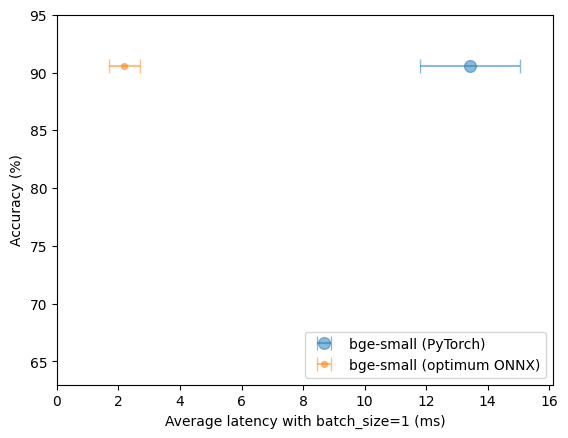

In [202]:
plot_metrics(perf_metrics)

By applying ONNX, we were able to improve the latency from 13.43ms per sample to 2.19ms per sample, for a speedup of 6.13x!

For further improvements, we recommend increasing the inference batch size, as this may also heavily improve the throughput. For example, setting the batch size to 128 reduces the latency further down to 0.3ms, and down to 0.2ms at a batch size of 2048.